In [1]:
import pandas as pd
import numpy as np
import collections
import matplotlib.pyplot as plt
%matplotlib inline

In [6]:
df=pd.read_csv("NED27.09.1-D-14.2.0-20170929.csv",skiprows=12)
df=df[np.isnan(df['redshift (z)'])] # only measurements without redshift data are useful here

In [7]:
def selectdata(mymethod,df):
    dfa=df[~np.isfinite(df.err)] # database of non reported errors
    df1=df[np.isfinite(df.err)] # remove measurements that do not report an error
    df1=df1[df1.err!=0] # remove measurements that report an error as zero ¬¬

# Create a dataframe with methods and number of occurrences
    counterM=collections.Counter(list(df1.Method)) # count measurements p. method
    dfmeth=(pd.DataFrame.from_dict(counterM,orient="index").reset_index()).rename(columns={'index':'method', 0:'count'})
    dfmeth=dfmeth.sort_values(by='count',ascending=False) # need to rewrite?
# Select a method for analysis
    df1=df1[df1.Method==mymethod] # choose a method
    namelist=list(df1['Galaxy ID']) # list of galaxies
    counter=collections.Counter(namelist) # count measurements per galaxy
# Select galaxies with a minimum number of measurements
    ulist=[]
    ulist2=[]
    nmeas=1
    for i in counter.keys():
        if counter[i]>nmeas:
            ulist+=[i] # all galaxies with more than n_meas measurements
        if counter[i]>=1:
            ulist2+=[i] # all galaxies with at least one measurement w/a reported error
    print('No. of Galaxies with reported errors is %i' % len(ulist2) )
    print('No. of Galaxies with more than %i measurements is %i' % (nmeas,len(ulist)) )
# Create database for bootstrap, remove unnecessary columns
    dfs=df1[np.in1d(df1['Galaxy ID'],ulist)] # dataframe with galaxies with more than nmeas measurements
    colu=list(df.columns)
    for i in ['Galaxy ID', 'm-M', 'err', 'D (Mpc)']:
        colu.remove(i)
    dfs.drop(colu, inplace=True, axis=1)
# Create database for non-reported errors
    df1a=dfa[dfa.Method==mymethod] # all measurements without reported errors
    elist=list(np.unique(df1a['Galaxy ID'])) # list of galaxies with measurements without reported errors
    dmeana=[]
    for i in elist:
        dfilter=np.in1d(df1a['Galaxy ID'],i)
        dummy=df1a[dfilter]
        dmeana+=[dummy['D (Mpc)'].mean()] # average reported distance (D), no need for weighted... there are no weights
    filtr=~np.in1d(elist,ulist2)
    nulista=np.asarray(elist)[filtr] # list of galaxies without reported errors
    dista=np.asarray(dmeana)[filtr] # mean distance of galaxies without reported errors
    print('No. of Galaxies without reported errors is %i' % len(nulista) )
    return ulist,dfs,nulista,dista,dfmeth,len(nulista),len(ulist),len(ulist2)

In [8]:
mymethod='Tully-Fisher'
ulist,dfs,nulista,dista,dfmeth,*mma=selectdata(mymethod,df)

No. of Galaxies with reported errors is 11376
No. of Galaxies with more than 1 measurements is 9100


/home/ecci/miniconda3/envs/py3/lib/python3.6/site-packages/ipykernel_launcher.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


No. of Galaxies without reported errors is 818


In [9]:
dfmeth.head()

,method,count
0,FP,130633
1,Tully-Fisher,56397
22,RR Lyrae,46152
7,Cepheids,20065
2,SNIa,8306


# Method Selection (can be skipped)

We look for the methods for which:

- The fraction of error-not-reported galaxies to useful measurements (no. of galaxies with n_meas>1) is greater than 5
- The number of galaxies with n_meas>1 is greater than 20.

These methods are in need of error prediction models.

In [10]:
meas=[]
for i in dfmeth.method:
    ulist,dfs,nulista,dista,dfmeth,*mma=selectdata(i,df);
    meas+=[mma]

No. of Galaxies with reported errors is 129054
No. of Galaxies with more than 1 measurements is 1218


/home/ecci/miniconda3/envs/py3/lib/python3.6/site-packages/ipykernel_launcher.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


No. of Galaxies without reported errors is 25
No. of Galaxies with reported errors is 11376
No. of Galaxies with more than 1 measurements is 9100
No. of Galaxies without reported errors is 818
No. of Galaxies with reported errors is 22930
No. of Galaxies with more than 1 measurements is 40
No. of Galaxies without reported errors is 54
No. of Galaxies with reported errors is 9239
No. of Galaxies with more than 1 measurements is 100
No. of Galaxies without reported errors is 5
No. of Galaxies with reported errors is 2714
No. of Galaxies with more than 1 measurements is 2296
No. of Galaxies without reported errors is 37
No. of Galaxies with reported errors is 2438
No. of Galaxies with more than 1 measurements is 404
No. of Galaxies without reported errors is 0
No. of Galaxies with reported errors is 562
No. of Galaxies with more than 1 measurements is 548
No. of Galaxies without reported errors is 2
No. of Galaxies with reported errors is 547
No. of Galaxies with more than 1 measurements 

In [11]:
meas=np.array(meas)
dfmeth['empty']=meas[:,0]
dfmeth['useful']=meas[:,1]
dfmeth['total']=meas[:,2]
dfmeth['e/u']=dfmeth['empty']/dfmeth['useful']*100
dfmeth['e/t']=dfmeth['empty']/dfmeth['total']*100

In [12]:
dfmeth[(dfmeth['e/u']>5)&(dfmeth['useful']>20)]
# que el porcentaje del numero de galaxias sin error reportado respecto a las galaxias con más de una medida
# sea mas que el 5%
# y que haya más de 20 galaxias con más de una medida

,method,count,empty,useful,total,e/u,e/t
1,Tully-Fisher,56397,818,9100,11376,8.989011,7.190577
22,RR Lyrae,46152,54,40,22930,135.000000,0.235499
11,TRGB,1710,22,308,462,7.142857,4.761905
8,CMD,1209,105,113,405,92.920354,25.925926
38,Eclipsing Binary,256,46,47,58,97.872340,79.310345
33,Red Clump,230,12,23,38,52.173913,31.578947
10,PNLF,198,8,45,69,17.777778,11.594203
23,SZ effect,137,10,38,40,26.315789,25.000000
6,Brightest Stars,128,92,21,82,438.095238,112.195122
29,Horizontal Branch,96,9,21,50,42.857143,18.000000


In [13]:
# number of galaxies with no reported errors for this method
mymethod='Tully-Fisher'
ulist,dfs,nulista,dista,dfmeth,*mma=selectdata(mymethod,df)

No. of Galaxies with reported errors is 11376
No. of Galaxies with more than 1 measurements is 9100


/home/ecci/miniconda3/envs/py3/lib/python3.6/site-packages/ipykernel_launcher.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


No. of Galaxies without reported errors is 818


In [18]:
mma

[818, 9100, 11376]

In [ ]:
# en nulista estan las que no tienen error

In [28]:
dfempty=df[np.in1d(df['Galaxy ID'],nulista)]

In [35]:
counter=collections.Counter(dfempty['Galaxy ID'])

In [63]:
dfempme=pd.DataFrame(list(counter.items()),columns=['gal','meas'])

In [66]:
(dfempme.meas==1).sum() # number of single-measurement TF reported distances without error

357

In [92]:
methn=[]
for i in nulista:
    methn+=[len(dfempty.Method[(dfempty['Galaxy ID']==i)&(dfempty.Method=='Tully-Fisher')])]
    

In [93]:
(np.array(methn)>1).sum() # number of galaxies with no tf error but with more than one TF measurement 

383

In [101]:
methnt=[]
for i in nulista:
    methnt+=[len(np.unique(dfempty.Method[(dfempty['Galaxy ID']==i)&(dfempty.Method!='Tully-Fisher')]))]
(np.array(methnt)>0).sum()    
# number of galaxies with no tf error but with more than one measurement using other methods

99

In [103]:
(np.array(methn)==1).sum() #

435

In [104]:
435+383

818

In [110]:
dftf=dfempty[dfempty.Method=='Tully-Fisher']

(array([    2.,   103.,     0.,    18.,     2.,   329.,     6.,     9.,
         1071.,   341.]),
 array([ 1980. ,  1983.6,  1987.2,  1990.8,  1994.4,  1998. ,  2001.6,
         2005.2,  2008.8,  2012.4,  2016. ]),
 <a list of 10 Patch objects>)

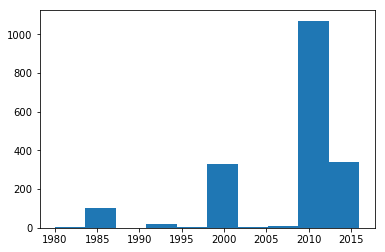

In [115]:
plt.hist(dftf['Date (Yr. - 1980)']+1980)

In [120]:
dftf[dftf['Date (Yr. - 1980)']>30].REFCODE

47        2013AJ....145..101K
871       2013AJ....145..101K
1260      2013AJ....145..101K
5108      2013AJ....145..101K
30135     2013AJ....145..101K
35548     2014A&A...562A..49M
49274     2013AJ....145..101K
50062     2013AJ....145..101K
53174     2013AJ....145..101K
60321     2013AJ....145..101K
60470     2013AJ....145..101K
61238     2013AJ....145..101K
62963     2013AJ....145..101K
63767     2013AJ....145..101K
116664    2013AJ....145..101K
117164    2013AJ....145..101K
117606    2013AJ....145..101K
118134    2015AstBu..70....1K
118195    2013AJ....145..101K
118494    2015AstBu..70....1K
119526    2015AstBu..70....1K
120486    2013AJ....145..101K
121152    2015AstBu..70....1K
122829    2015AstBu..70....1K
124602    2015AstBu..70....1K
125704    2015AstBu..70....1K
128402    2013AJ....145..101K
128562    2015AstBu..70....1K
128723    2015AstBu..70....1K
129499    2013AJ....145..101K
                 ...         
258391    2014Ap.....57..457K
260191    2014Ap.....57..457K
260784    

In [102]:
dedd=pd.read_csv('EDDtable14Mar2018170435.txt',low_memory=False,header=0,skiprows=[0,2,3,4])

In [32]:
ledd=np.unique(dedd.Name.astype('str'))[:-1]

In [20]:
ledd

array(['+00-04-045', '+00-04-056', '+03-38-030', ..., 'XJ23490014',
       'XJ23491554', 'd0958+66'], dtype=object)

In [36]:
lned=np.loadtxt('calculated.txt',dtype='str')

In [39]:
lned=np.array([i[2:-1] for i in lned])

In [40]:
lned

array(['UGC12889', 'KUG2357+228', '2MFGC00003', ..., 'NGC7800',
       '2MASXJ23594628+0452385', 'AGC332118'], 
      dtype='<U24')

In [41]:
len(lned)

9100

In [42]:
len(ledd)

10616

In [47]:
coinc=lned[np.in1d(lned,ledd)]

In [48]:
len(coinc)

2380

In [49]:
coinc

array(['UGC12898', 'UGC12900', 'UGC12901', ..., 'UGC12882', 'UGC12886',
       'NGC7800'], 
      dtype='<U24')

In [103]:
dedd.columns

Index(['pgc', 'Dist', 'Nd', 'DM', 'eDM', 'C', 'T', 'L', 'M', 'S', 'N', 'H',
       'I', 'F', 'DM2', 'eD2', 'SNIa', 'Ns', 'DMsn', 'DMsp', 'eDsp', 'DM6d',
       'eD6d', 'Mt', 'RAJ', 'DeJ', 'Glon', 'Glat', 'SGL', 'SGB', 'Ty', 'Asf',
       'Btot', 'Ks', 'Vhel', 'Vgsr', 'Vls', 'Vcmb', 'Vmod', 'Name', 'Nest',
       'Ndgp', 'DMgp', 'eDgp', 'Dgp', 'Abell', 'GroupName', 'NV', 'PGC1',
       'Glongp', 'Glatgp', 'SGLgp', 'SGBgp', 'lgLgp', 'cf', 'sigp', 'R2t',
       'Vhgp', 'Vggp', 'Vlsgp', 'Vcgp', 'Vmgp', 'Vrms', 'bwMass12', 'L_Mass12',
       'LDC', 'HDC', '2M++', 'MKgp', 'Icnt'],
      dtype='object')

(array([  1.72300000e+03,   0.00000000e+00,   2.04000000e+02,
          0.00000000e+00,   3.40000000e+01,   0.00000000e+00,
          3.00000000e+00,   0.00000000e+00,   0.00000000e+00,
          1.00000000e+00]),
 array([ 2. ,  2.5,  3. ,  3.5,  4. ,  4.5,  5. ,  5.5,  6. ,  6.5,  7. ]),
 <a list of 10 Patch objects>)

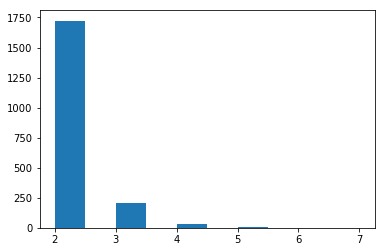

In [104]:
plt.hist(dedd.Nd[dedd.Nd>1])

In [107]:
dedd[dedd.Nd==7].T

,5265
pgc,39600
Dist,7.31
Nd,7
DM,29.32
eDM,0.1
C,C
T,T
L,L
M,M
S,S


In [57]:
dedd.head()

,pgc,Dist,Nd,DM,eDM,C,T,L,M,S,...,Vcgp,Vmgp,Vrms,bwMass12,L_Mass12,LDC,HDC,2M++,MKgp,Icnt
0,4,50.58,1,33.52,0.4,NaN,NaN,NaN,NaN,NaN,...,4005,4048,25.0,0.0,9.747,0,0,0,0,0
1,27,150.66,1,35.89,0.5,NaN,NaN,NaN,NaN,NaN,...,10959,11275,NaN,0.0,0.000,0,0,0,0,0
2,40,116.95,1,35.34,0.5,NaN,NaN,NaN,NaN,NaN,...,6919,7045,0.0,0.0,3.960,0,0,0,0,0
3,51,240.99,1,36.91,0.5,NaN,NaN,NaN,NaN,NaN,...,14743,15315,132.0,0.0,253.333,0,0,0,0,0
4,55,73.79,1,34.34,0.4,NaN,NaN,NaN,NaN,NaN,...,4454,4507,NaN,0.0,0.000,0,0,0,0,0


In [88]:
clist=list(dedd.columns[5:14])
clist.remove('H')
clist.remove('I')

In [93]:
boo=(dedd.H=='H')

for c in clist:
    boo&=dedd[c]!=c

In [95]:
np.unique(dedd.Nd[boo])

array([1, 2])

In [96]:
dedd.columns

Index(['pgc', 'Dist', 'Nd', 'DM', 'eDM', 'C', 'T', 'L', 'M', 'S', 'N', 'H',
       'I', 'F', 'DM2', 'eD2', 'SNIa', 'Ns', 'DMsn', 'DMsp', 'eDsp', 'DM6d',
       'eD6d', 'Mt', 'RAJ', 'DeJ', 'Glon', 'Glat', 'SGL', 'SGB', 'Ty', 'Asf',
       'Btot', 'Ks', 'Vhel', 'Vgsr', 'Vls', 'Vcmb', 'Vmod', 'Name', 'Nest',
       'Ndgp', 'DMgp', 'eDgp', 'Dgp', 'Abell', 'GroupName', 'NV', 'PGC1',
       'Glongp', 'Glatgp', 'SGLgp', 'SGBgp', 'lgLgp', 'cf', 'sigp', 'R2t',
       'Vhgp', 'Vggp', 'Vlsgp', 'Vcgp', 'Vmgp', 'Vrms', 'bwMass12', 'L_Mass12',
       'LDC', 'HDC', '2M++', 'MKgp', 'Icnt'],
      dtype='object')

In [101]:
dedd[cols=['pgc', 'Dist']]

SyntaxError: invalid syntax (<ipython-input-101-125bd88c0d95>, line 1)